In [57]:
import pandas as pd

def load_dataset():
  column_names = [
      "srcip", "sport", "dstip", "dsport", "proto", "state", "dur", "sbytes", "dbytes", "sttl", "dttl",
      "sloss", "dloss", "service", "Sload", "Dload", "Spkts", "Dpkts", "swin", "dwin", "stcpb", "dtcpb",
      "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "Sjit", "Djit", "Stime", "Ltime", "Sintpkt",
      "Dintpkt", "tcprtt", "synack", "ackdat", "is_sm_ips_ports", "ct_state_ttl", "ct_flw_http_mthd",
      "is_ftp_login", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm",
      "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat", "Label"
  ]

  df1 = pd.read_csv("DS_term/UNSW-NB15_1.csv", header=None, names=column_names, low_memory=False)
  df2 = pd.read_csv("DS_term/UNSW-NB15_2.csv", header=None, names=column_names, low_memory=False)
  df3 = pd.read_csv("DS_term/UNSW-NB15_3.csv", header=None, names=column_names, low_memory=False)
  df4 = pd.read_csv("DS_term/UNSW-NB15_4.csv", header=None, names=column_names, low_memory=False)

  df1_0 = df1[df1['Label'] == 0]
  df2_0 = df2[df2['Label'] == 0]
  df3_0 = df3[df3['Label'] == 0]
  df4_0 = df4[df4['Label'] == 0]

  df1_1 = df1[df1['Label'] == 1]
  df2_1 = df2[df2['Label'] == 1]
  df3_1 = df3[df3['Label'] == 1]
  df4_1 = df4[df4['Label'] == 1]

  df_label0 = pd.concat([df1_0, df2_0, df3_0, df4_0], ignore_index=True)
  df_label1 = pd.concat([df1_1, df2_1, df3_1, df4_1], ignore_index=True)


  df_label1 = df_label1[df_label1['attack_cat'].isin(["Generic", "Reconnaissance"])]
  df_label0 = df_label0.sample(frac=0.25)

  df_final = pd.concat([df_label0, df_label1])
  df_final = df_final.drop('attack_cat', axis=1)

  df_final.to_csv("DS_term/1_Raw_DataSet.csv", index=False)

if __name__ == '__main__':
  load_dataset()

ct_flw_http_mthd    472383
is_ftp_login        490806
dtype: int64
-----
<IntegerArray>
[0, 1, 3, 5, 4, 2, 6, 8]
Length: 8, dtype: Int64
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: ct_ftp_cmd, dtype: Int64
Int64
149599
중복 처리 이후
390752
아웃라이어 처리 이전
366157
아웃라이어 처리 이후
88271


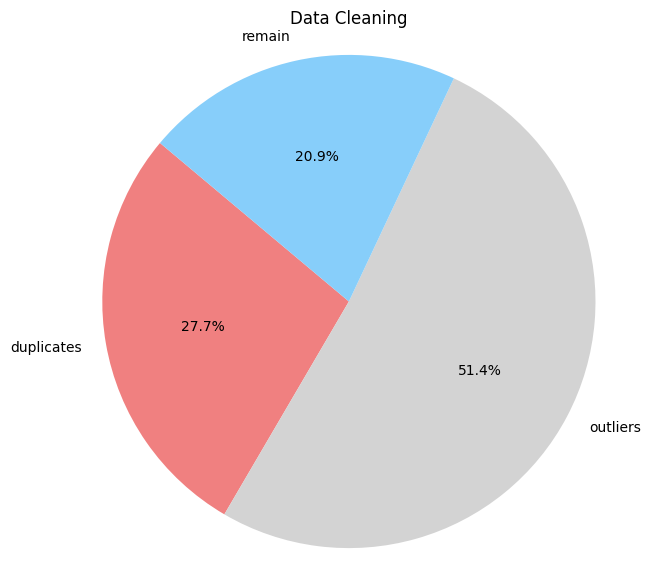

-----
<IntegerArray>
[0, 2, 1, 4, 3, 5, 6]
Length: 7, dtype: Int64
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: ct_ftp_cmd, dtype: Int64
Int64


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def remove_outliers_iqr(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include='number').columns

    df_clean = df.copy()

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    return df_clean

def data_cleaning(df, is_test=False, is_plot=True):
  # 해당 컬럼의 결측치 0으로 대체
  df['ct_flw_http_mthd'] = df['ct_flw_http_mthd'].fillna(0).astype(np.uint8)
  df['is_ftp_login'] = df['is_ftp_login'].fillna(0).astype(np.uint8)
  df['ct_ftp_cmd'].replace(' ', np.nan, regex=True, inplace=True)
  df['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'], errors='coerce')
  df['ct_ftp_cmd'] = df['ct_ftp_cmd'].fillna(0).astype('Int64')

  print("-----")
  print(df['ct_ftp_cmd'].unique())
  print(df['ct_ftp_cmd'].head(10))
  print(df['ct_ftp_cmd'].dtype)

  # 원본 데이터 행 개수 저장
  original_count = df.shape[0]

  # 중복 데이터 확인 / 제거
  if not is_test:
    duplicates_count = df.duplicated().sum()
    print(duplicates_count)
    df = df.drop_duplicates()

    print("중복 처리 이후")
    print(df.shape[0])

  # 0, 1 로 이루어진 범주형 변수 uint8 타입으로 변환
  for col in df.columns:
      unique_vals = df[col].dropna().unique()
      if set(unique_vals).issubset({0, 1}):
          df[col] = df[col].astype(np.uint8)

  df_final = None
  if not is_test:
    df_normal = df[df['Label'] == 0]
    df_attack = df[df['Label'] == 1]

    print("아웃라이어 처리 이전")
    print(df_normal.shape[0])

    before_outlier_count = df_normal.shape[0]

    df_normal_cleaned = remove_outliers_iqr(df_normal) # 아웃 라이어 처리

    after_outlier_count = df_normal_cleaned.shape[0]

    print("아웃라이어 처리 이후")
    print(df_normal_cleaned.shape[0])

    df_final = pd.concat([df_attack, df_normal_cleaned])
  else:
    df_final = df

  # 전처리 단계에서 제거할 피처
  columns_to_drop = ['srcip', 'dstip', 'Stime', 'Ltime', 'stcpb', 'dtcpb']
  df_final = df_final.drop(columns=columns_to_drop, errors='ignore')

  if is_test:
    df_final.to_csv("DS_term/2_Cleaning_TestDataSet.csv", index=False)
  else:
    df_final.to_csv("DS_term/2_Cleaning_DataSet.csv", index=False)

  if is_plot:
    outliers_removed = before_outlier_count - after_outlier_count
    final_remain = original_count - (duplicates_count + outliers_removed)

    labels = ['duplicates', 'outliers', 'remain']
    sizes = [duplicates_count, outliers_removed, final_remain]
    colors = ['lightcoral', 'lightgray', 'lightskyblue']

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Data Cleaning')
    plt.axis('equal')
    plt.show()

if __name__ == '__main__':
  raw_dataset = pd.read_csv("DS_term/1_Raw_DataSet.csv")

  # 결측치 개수 확인
  null_counts = raw_dataset.isnull().sum()
  print(null_counts[null_counts > 0])

  df_train, processed_test = train_test_split(
      raw_dataset,
      test_size = 0.3,
      random_state = 128,
      stratify=raw_dataset['Label']
  )
  df_train.reset_index(drop=True, inplace=True)
  processed_test.reset_index(drop=True, inplace=True)

  # Train-Test 데이터셋 분리
  data_cleaning(df_train)
  data_cleaning(processed_test, is_test=True, is_plot=False)


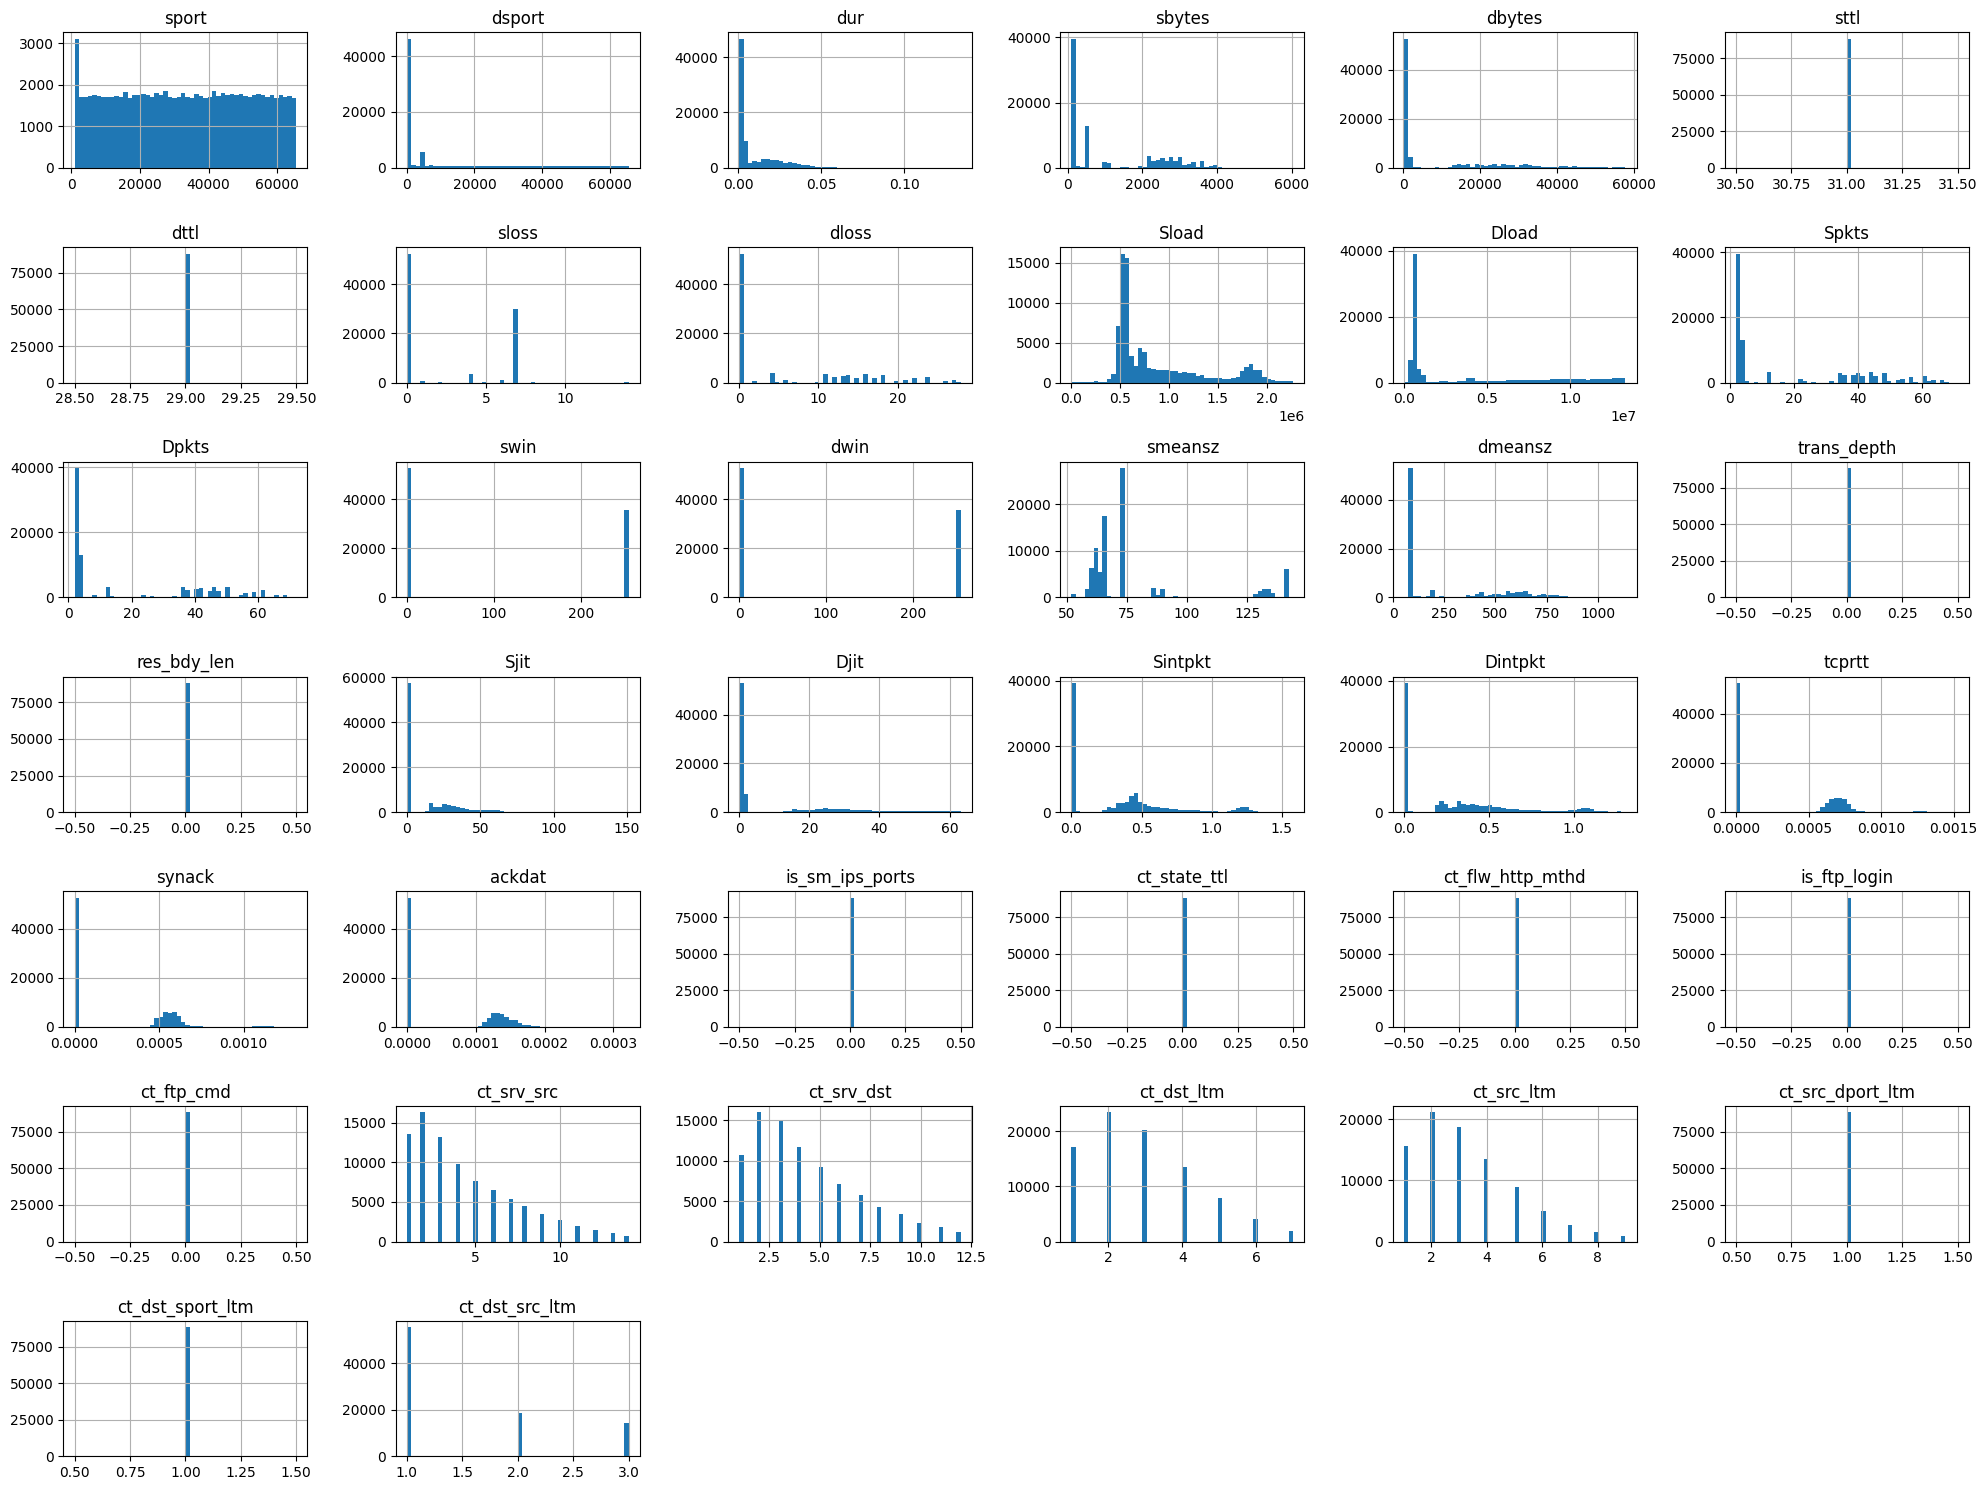

sport               int64
dsport              int64
dur               float64
sbytes            float64
dbytes            float64
                   ...   
service_radius       bool
service_smtp         bool
service_snmp         bool
service_ssh          bool
service_ssl          bool
Length: 188, dtype: object


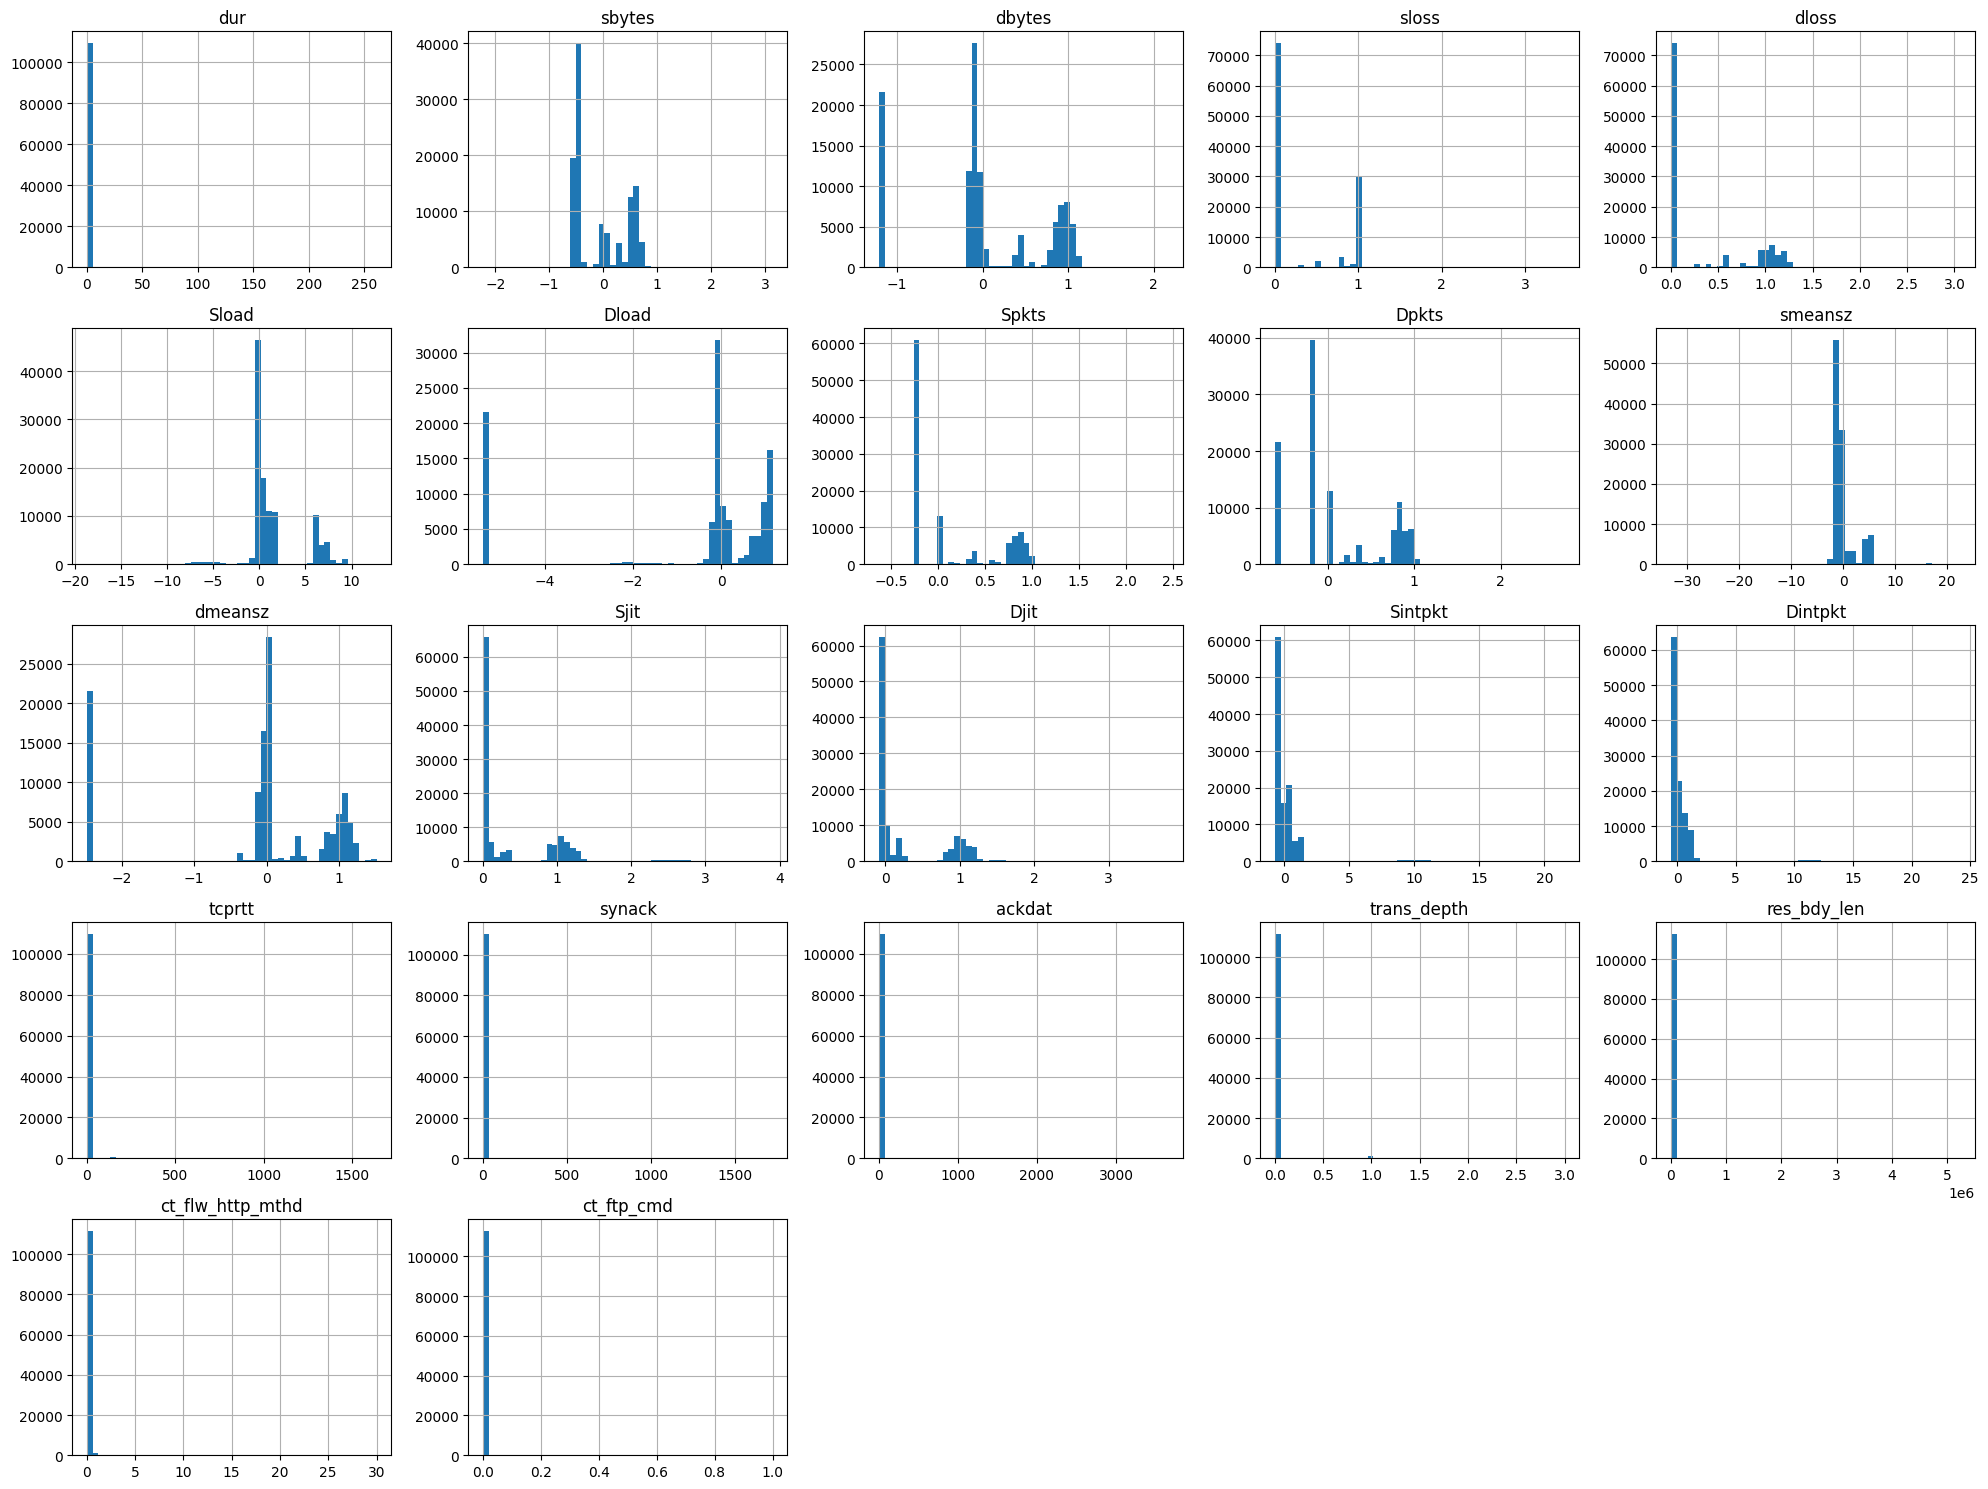

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import seaborn as sns

def data_scaling(is_plot=True):
  # 1. 데이터 로드
  df = pd.read_csv("DS_term/2_Cleaning_DataSet.csv")

  # 2. 정상/공격 분리
  df_normal = df[df['Label'] == 0].copy()
  df_attack = df[df['Label'] == 1].copy()

  df_normal_numeric = df_normal.select_dtypes(include=['number']).drop(columns=['Label'], errors='ignore').copy()
  if is_plot:
    df_normal_numeric.hist(figsize=(20, 15), bins=50)
    plt.tight_layout()
    plt.show()

  # 3. 로그 변환 대상
  log_transform_cols = [
      'dur', 'sbytes', 'dbytes', 'sloss', 'dloss', 'Sload', 'Dload',
      'Spkts', 'Dpkts', 'smeansz', 'dmeansz',
      'Sjit', 'Djit', 'Sintpkt', 'Dintpkt'
  ]

  df_normal[log_transform_cols] = df_normal[log_transform_cols].apply(lambda x: np.log1p(x))
  df_attack[log_transform_cols] = df_attack[log_transform_cols].apply(lambda x: np.log1p(x))
  df[log_transform_cols] = df[log_transform_cols].apply(lambda x: np.log1p(x))

  # 4. 스케일링: RobustScaler
  robust_scaler = RobustScaler()
  robust_scaler.fit(df_normal[log_transform_cols])

  df[log_transform_cols] = robust_scaler.transform(df[log_transform_cols])

  # 5. StandardScaler 대상
  standard_cols = ['tcprtt', 'synack', 'ackdat']
  standard_scaler = StandardScaler()
  standard_scaler.fit(df_normal[standard_cols])

  df[standard_cols] = standard_scaler.transform(df[standard_cols])

  # 6. MinMaxScaler 대상
  minmax_cols = ['trans_depth', 'res_bdy_len', 'ct_flw_http_mthd', 'ct_ftp_cmd']
  minmax_scaler = MinMaxScaler()
  minmax_scaler.fit(df_normal[minmax_cols])

  df[minmax_cols] = minmax_scaler.transform(df[minmax_cols])


  # 범주형 컬럼 자동 추출
  categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
  # 'Label' 컬럼 제외
  categorical_cols = [col for col in categorical_cols if col != 'Label']
  # 원-핫 인코딩
  df_final= pd.get_dummies(df, columns=categorical_cols)

  # 11. 저장
  df_final.to_csv("DS_term/3_Preprocessing_DataSet.csv", index=False)

  if is_plot:
    print(df_final.dtypes)

    scaled_cols = log_transform_cols + standard_cols + minmax_cols
    df[scaled_cols].hist(figsize=(20, 15), bins=50)
    plt.tight_layout()
    plt.show()

  # 12. 테스트 데이터 스케일링
  df_test = pd.read_csv("DS_term/2_Cleaning_TestDataSet.csv")
  df_test[log_transform_cols] = robust_scaler.transform(df_test[log_transform_cols])
  df_test[standard_cols] = standard_scaler.transform(df_test[standard_cols])
  df_test[minmax_cols] = minmax_scaler.transform(df_test[minmax_cols])
  df_test_final = pd.get_dummies(df_test, columns=categorical_cols)
  df_test_final.to_csv("DS_term/3_Preprocessing_TestDataSet.csv", index=False)

if __name__ == '__main__':
  data_scaling()

Number of selected features: 13
Selected feature list: ['proto_ospf' 'proto_sctp' 'proto_udp' 'state_CON' 'state_INT' 'state_REQ'
 'service_-' 'service_dns' 'service_ftp-data' 'service_http'
 'service_smtp' 'service_ssh' 'service_ssl']


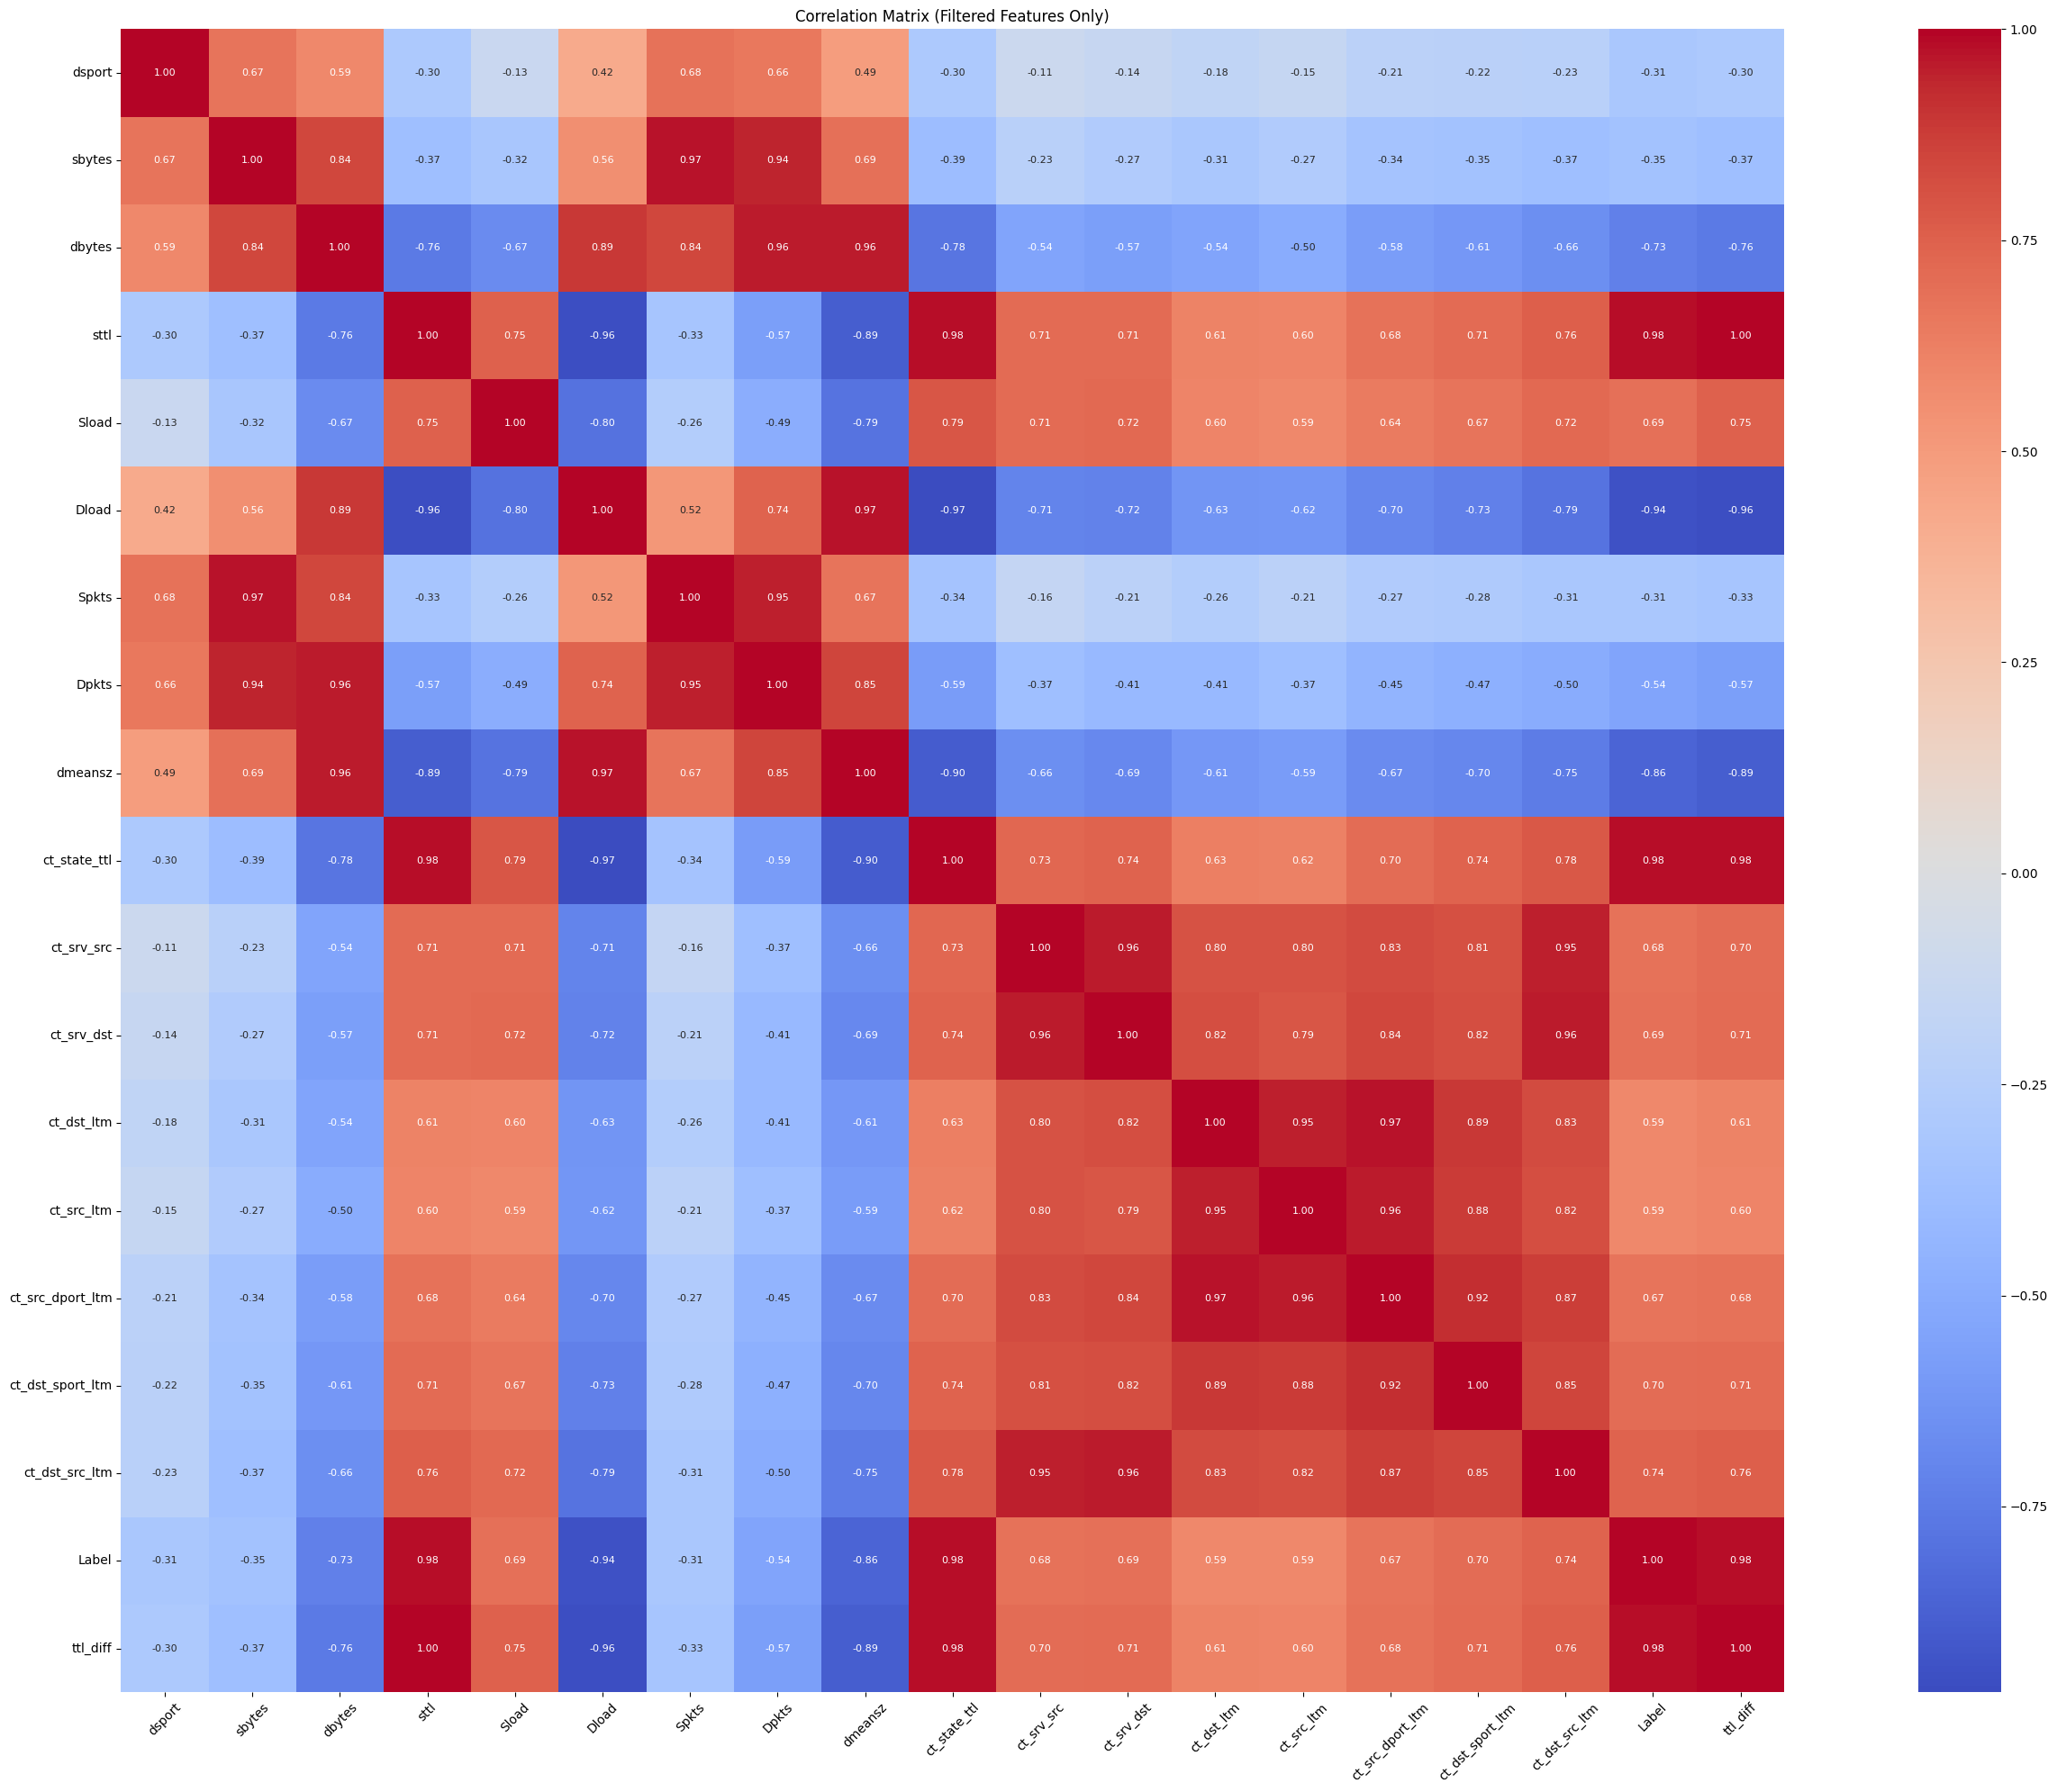

Number of features before variance filtering: 18
Spkts               2.145816e-01
sbytes              2.346360e-01
Dpkts               2.973754e-01
dbytes              5.464784e-01
ct_state_ttl        6.331387e-01
dmeansz             1.442376e+00
Dload               5.344966e+00
Sload               8.557935e+00
ct_dst_sport_ltm    2.238411e+01
ct_dst_ltm          4.238006e+01
ct_src_ltm          4.326826e+01
ct_src_dport_ltm    4.655592e+01
ct_srv_dst          9.360855e+01
ct_srv_src          9.458170e+01
ct_dst_src_ltm      1.050973e+02
ttl_diff            8.074454e+03
sttl                8.214763e+03
dsport              3.537078e+08
dtype: float64
Number of features after variance filtering: 18
['dsport', 'sbytes', 'dbytes', 'sttl', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'dmeansz', 'ct_state_ttl', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ttl_diff', 'proto_ospf', 'proto_sctp', 'proto_udp', 'state_CON', 'state_INT',

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

def data_preprocessing(is_plot=True):
  # Load the dataset
  df = pd.read_csv("DS_term/3_Preprocessing_DataSet.csv")
  df_test = pd.read_csv("DS_term/3_Preprocessing_TestDataSet.csv") # 테스트 데이터셋 로드

  # feature creation - load_ratio
  df['load_ratio'] = df['Sload'] / (df['Dload'] + 1e-6)
  df_test['load_ratio'] = df_test['Sload'] / (df_test['Dload'] + 1e-6)

  # feature creation - ttl_diff
  df['ttl_diff'] = abs(df['sttl'] - df['ct_state_ttl'])
  df_test['ttl_diff'] = abs(df_test['sttl'] - df_test['ct_state_ttl'])

  target_col = 'Label'

  # Identify numerical and categorical columns
  numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
  categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

  # Define prefixes of one-hot encoded columns to exclude
  exclude_prefixes = ('proto_', 'state_', 'service_')

  # Get all one-hot encoded columns based on prefixes
  excluded_cols = [col for col in df.columns if col.startswith(exclude_prefixes)]

  # Logistic Regression-based feature selection using L1 regularization
  X = df[excluded_cols].copy()
  target = df[target_col]

  model = LogisticRegression(penalty='l1', solver='liblinear', C=0.05, class_weight='balanced', max_iter=1000, random_state=42)
  model.fit(X, target)
  selected_features = np.array(X.columns)[model.coef_[0] != 0]

  print(f"Number of selected features: {len(selected_features)}")
  print("Selected feature list:", selected_features)

  # Create DataFrame with selected features + target
  df_LogisticRegression_selected = df[list(selected_features) + [target_col]]

  # Correlation-based feature selection for numerical features
  corr_target_cols = [col for col in numeric_cols if col not in excluded_cols or col == target_col]
  correlations = df[corr_target_cols].corr()[target_col].abs()
  selected_numeric = correlations[correlations > 0.3].index.tolist()

  # Plot correlation heatmap for selected numeric features
  if is_plot:
    corr_matrix = df[selected_numeric].corr().round(2)
    plt.figure(figsize=(30, 20))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True, annot_kws={"size": 8})
    plt.title("Correlation Matrix (Filtered Features Only)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("correlation.png", dpi=300, bbox_inches='tight')
    plt.show()

  # Apply variance threshold to remove low-variance features
  df_numeric_selected = df[selected_numeric].drop(columns=[target_col])
  print("Number of features before variance filtering:", df_numeric_selected.shape[1])

  selector = VarianceThreshold(threshold=0.01)
  selected_variance_data = selector.fit_transform(df_numeric_selected)
  selected_variance_features = df_numeric_selected.columns[selector.get_support(indices=True)]
  df_numeric_selected = pd.DataFrame(selected_variance_data, columns=selected_variance_features)

  # Print variance values of selected features
  variances = df_numeric_selected.var()
  print(variances.sort_values())
  print("Number of features after variance filtering:", df_numeric_selected.shape[1])

  # Combine numeric features and Logistic Regression-selected features
  df_filtered = pd.concat([df_numeric_selected, df_LogisticRegression_selected], axis=1)

  # Save the final feature-engineered dataset
  df_filtered.to_csv('DS_term/4_Feature_engineering_DataSet.csv', index=False)

  print(df_filtered.columns.tolist())

  # 테스트 데이터셋 피쳐 추출
  df_test_filtered = df_test[df_filtered.columns]
  df_filtered.to_csv('DS_term/4_Feature_engineering_TestDataSet.csv', index=False)

if __name__ == '__main__':
  data_preprocessing()


--- 데이터 불러오기 ---
                 srcip  sport           dstip dsport proto state       dur  \
0           59.166.0.5  40772   149.171.126.5  52829   tcp   FIN  0.022112   
1           59.166.0.5   6527   149.171.126.0     53   udp   CON  0.001067   
2       149.171.126.15  47439    175.45.176.3     53   udp   INT  0.000007   
3           59.166.0.3  37770   149.171.126.5  38417   tcp   FIN  0.049909   
4           59.166.0.4  48946   149.171.126.6  46934   tcp   FIN  0.018896   
...                ...    ...             ...    ...   ...   ...       ...   
771926    175.45.176.0  47439  149.171.126.10     53   udp   INT  0.000001   
771927    175.45.176.0  47439  149.171.126.10     53   udp   INT  0.000001   
771928    175.45.176.0  47439  149.171.126.10     53   udp   INT  0.000001   
771929    175.45.176.0  47439  149.171.126.10     53   udp   INT  0.000001   
771930    175.45.176.0  47439  149.171.126.10     53   udp   INT  0.000001   

        sbytes  dbytes  sttl  ...  is_ftp_log

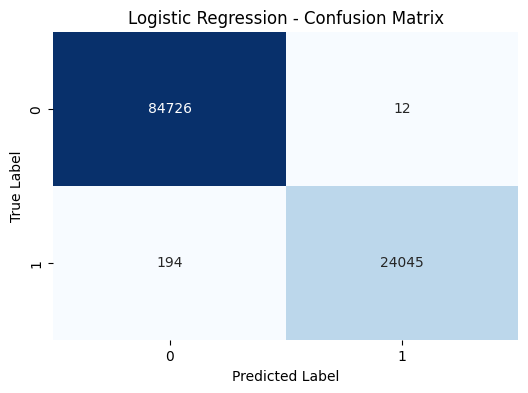

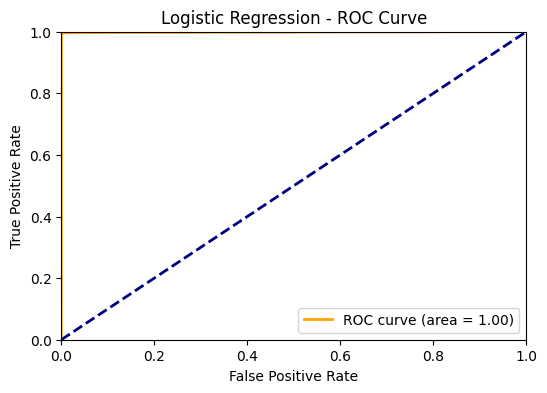

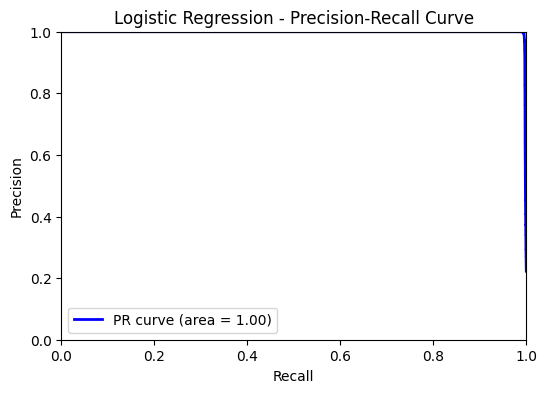


--- Logistic Regression 모델 성능 평가 결과 ---
정확도 (Accuracy): 0.9981
정밀도 (Precision): 0.9981
재현율 (Recall): 0.9981
F1-점수 (F1-Score): 0.9981
ROC AUC: 0.9987

혼동 행렬 (Confusion Matrix):
[[84726    12]
 [  194 24045]]

--- 모델: Random Forest ---
모델 학습 중...
모델 학습 완료.


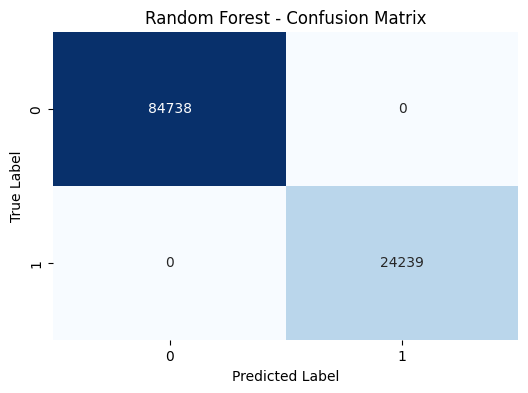

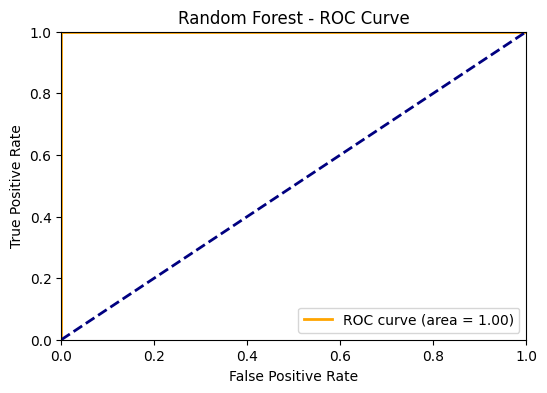

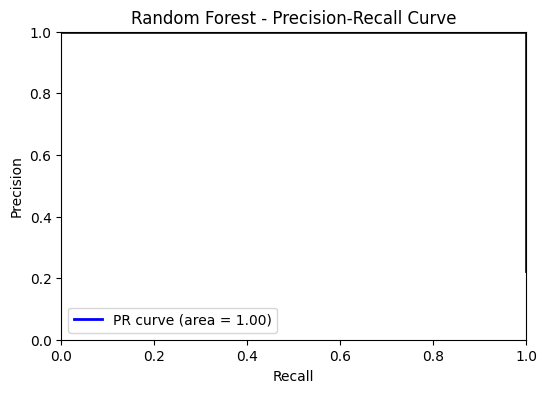


--- Random Forest 모델 성능 평가 결과 ---
정확도 (Accuracy): 1.0000
정밀도 (Precision): 1.0000
재현율 (Recall): 1.0000
F1-점수 (F1-Score): 1.0000
ROC AUC: 1.0000

혼동 행렬 (Confusion Matrix):
[[84738     0]
 [    0 24239]]

--- 1번째 Fold  ---
-----
<IntegerArray>
[0, 1, 4, 6, 2, 5, 3, 8]
Length: 8, dtype: Int64
0     0
1     0
2     0
3     0
5     0
6     0
7     0
8     0
9     0
11    0
Name: ct_ftp_cmd, dtype: Int64
Int64
141067
중복 처리 이후
373554
아웃라이어 처리 이전
349379
아웃라이어 처리 이후
83707
-----
<IntegerArray>
[0, 1, 2, 3, 4, 5, 6]
Length: 7, dtype: Int64
4     0
10    0
16    0
19    0
26    0
28    0
30    0
33    0
35    0
38    0
Name: ct_ftp_cmd, dtype: Int64
Int64
Number of selected features: 13
Selected feature list: ['proto_ospf' 'proto_sctp' 'proto_udp' 'state_CON' 'state_INT' 'state_REQ'
 'service_-' 'service_dns' 'service_ftp-data' 'service_http'
 'service_smtp' 'service_ssh' 'service_ssl']
Number of features before variance filtering: 18
Spkts               2.125548e-01
sbytes              2.330069e-

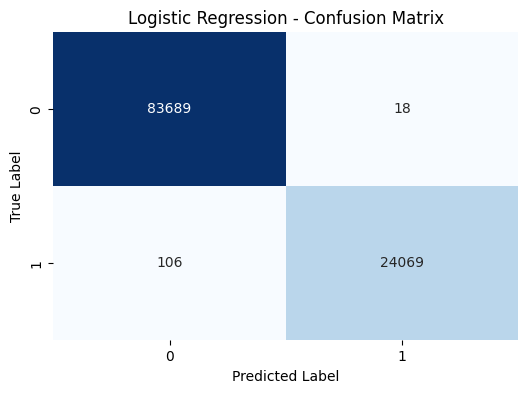

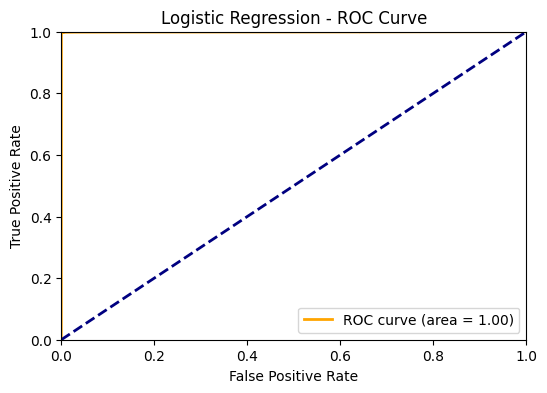

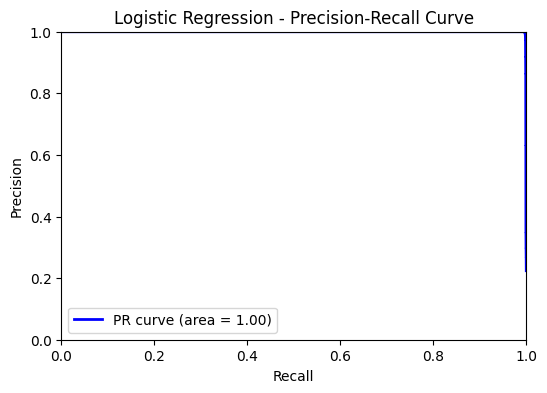


--- Logistic Regression 모델 성능 평가 결과 ---
정확도 (Accuracy): 0.9989
정밀도 (Precision): 0.9989
재현율 (Recall): 0.9989
F1-점수 (F1-Score): 0.9988
ROC AUC: 0.9993

혼동 행렬 (Confusion Matrix):
[[83689    18]
 [  106 24069]]

--- 모델: Random Forest ---
모델 학습 중...
모델 학습 완료.


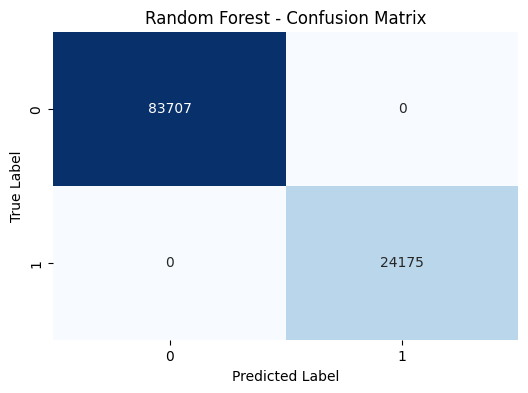

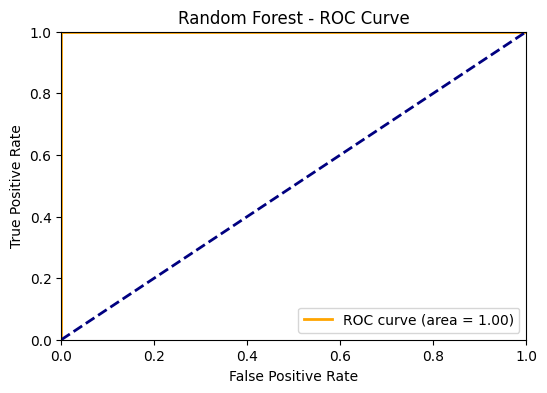

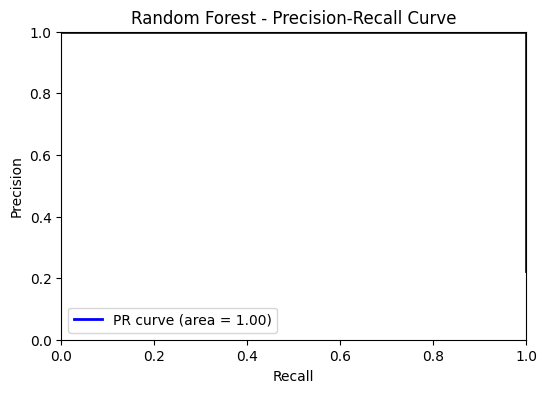


--- Random Forest 모델 성능 평가 결과 ---
정확도 (Accuracy): 1.0000
정밀도 (Precision): 1.0000
재현율 (Recall): 1.0000
F1-점수 (F1-Score): 1.0000
ROC AUC: 1.0000

혼동 행렬 (Confusion Matrix):
[[83707     0]
 [    0 24175]]

--- 2번째 Fold  ---
-----
<IntegerArray>
[0, 1, 4, 6, 2, 3, 5, 8]
Length: 8, dtype: Int64
0     0
2     0
4     0
6     0
7     0
9     0
10    0
11    0
12    0
14    0
Name: ct_ftp_cmd, dtype: Int64
Int64
141305
중복 처리 이후
373316
아웃라이어 처리 이전
349095
아웃라이어 처리 이후
84708
-----
<IntegerArray>
[0, 1, 4, 5, 3, 6, 2]
Length: 7, dtype: Int64
1     0
3     0
5     0
8     0
13    0
15    0
17    0
21    0
22    0
23    0
Name: ct_ftp_cmd, dtype: Int64
Int64
Number of selected features: 13
Selected feature list: ['proto_ospf' 'proto_sctp' 'proto_udp' 'state_INT' 'state_REQ' 'service_-'
 'service_dhcp' 'service_dns' 'service_ftp-data' 'service_http'
 'service_smtp' 'service_ssh' 'service_ssl']
Number of features before variance filtering: 18
Spkts               2.077512e-01
sbytes              2.29075

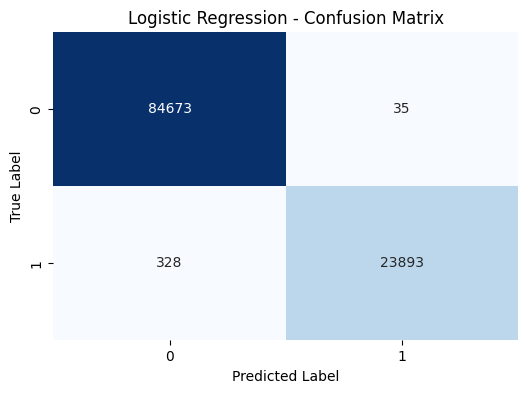

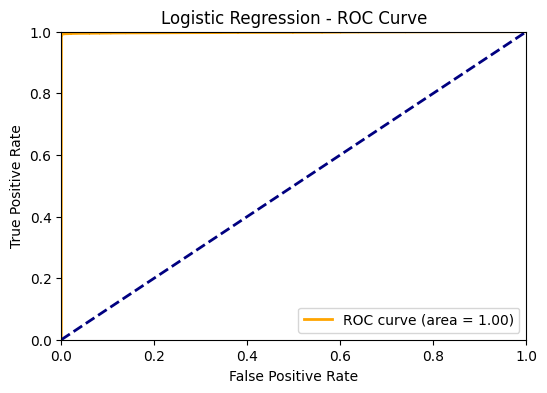

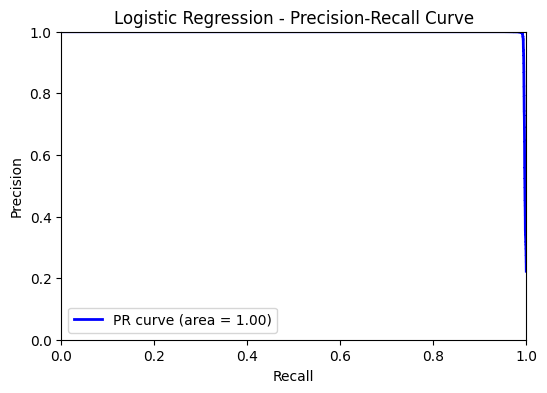


--- Logistic Regression 모델 성능 평가 결과 ---
정확도 (Accuracy): 0.9967
정밀도 (Precision): 0.9967
재현율 (Recall): 0.9967
F1-점수 (F1-Score): 0.9967
ROC AUC: 0.9979

혼동 행렬 (Confusion Matrix):
[[84673    35]
 [  328 23893]]

--- 모델: Random Forest ---
모델 학습 중...
모델 학습 완료.


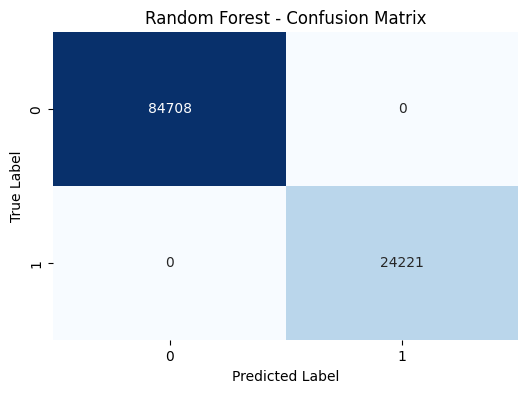

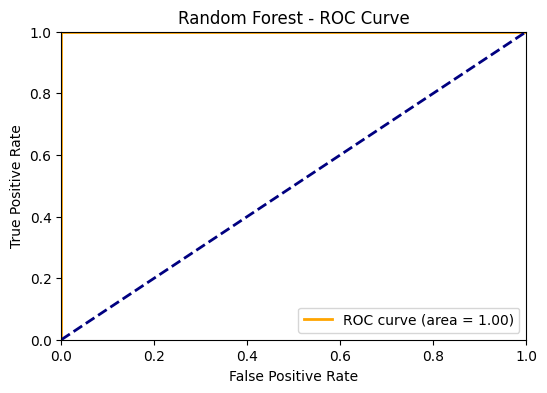

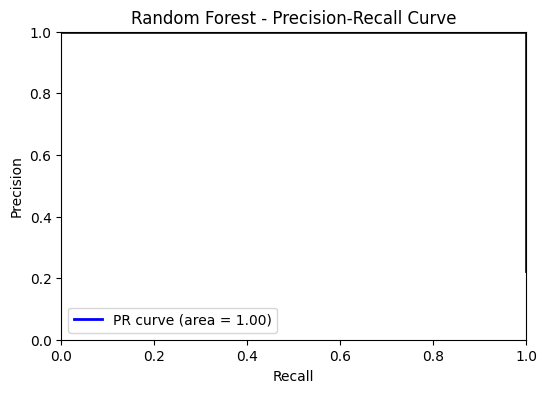


--- Random Forest 모델 성능 평가 결과 ---
정확도 (Accuracy): 1.0000
정밀도 (Precision): 1.0000
재현율 (Recall): 1.0000
F1-점수 (F1-Score): 1.0000
ROC AUC: 1.0000

혼동 행렬 (Confusion Matrix):
[[84708     0]
 [    0 24221]]


모델링 절차 완료.


In [64]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# --- 데이터 불러오기 ---
print("\n--- 데이터 불러오기 ---")
df = pd.read_csv("DS_term/1_Raw_DataSet.csv")
print(df)

# --- 사용할 모델 정의 ---
print("\n--- 모델 정의 ---")
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
}
print(f"정의된 모델: {list(models.keys())}")

# --- K-Fold Cross Validation ---
kf = KFold(n_splits=3, shuffle=True, random_state=42)

model_results = {} # 모델 별 결과 저장용 딕셔너리

for round, (train_index, test_index) in enumerate(kf.split(df)):

  print(f"\n--- {round}번째 Fold  ---")
  # --- 1. 데이터 분할 (학습/테스트) ---
  df_train, df_test = df.iloc[train_index], df.iloc[test_index]

  # --- 2. 데이터 클리닝 ---
  data_cleaning(df_train, is_test=False, is_plot=False)
  data_cleaning(df_test, is_test=True, is_plot=False)

  # --- 3. 데이터 스케일링 ---
  data_scaling(is_plot=False)

  # --- 4. 데이터 전처리 ---
  data_preprocessing(is_plot=False)

  # --- 5. 전처리 된 데이터 불러오기 ---
  processed_train = pd.read_csv("DS_term/4_Feature_engineering_DataSet.csv")
  processed_test = pd.read_csv("DS_term/4_Feature_engineering_TestDataSet.csv")

  X_train = processed_train.drop(["Label"], axis=1)
  X_test = processed_test.drop("Label", axis=1)
  y_train = processed_train["Label"]
  y_test = processed_test["Label"]

  # --- 6. 모델 학습, 예측 및 평가 ---
  model_results = {}

  print("\n\n--- 모델 학습, 예측 및 평가 시작 ---")
  for model_name, model_instance in models.items():
      print(f"\n--- 모델: {model_name} ---")

      # --- 6.1. 모델 학습 ---
      print("모델 학습 중...")
      model_instance.fit(X_train, y_train)
      print("모델 학습 완료.")

      # --- 6.2. 테스트 데이터 예측 ---
      y_pred = model_instance.predict(X_test)
      if hasattr(model_instance, "predict_proba"):
          y_pred_proba = model_instance.predict_proba(X_test)[:, 1] # 이진 분류 가정
      else:
          y_pred_proba = None

      # --- 6.3. 기본 평가 지표 계산 ---
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
      recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
      f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

      # --- 6.4. 혼동 행렬 시각화 ---
      cm = confusion_matrix(y_test, y_pred)
      plt.figure(figsize=(6, 4))
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
      plt.title(f"{model_name} - Confusion Matrix")
      plt.xlabel("Predicted Label")
      plt.ylabel("True Label")
      plt.show()

      roc_auc = None
      if y_pred_proba is not None:
          try:
            # --- 6.5. ROC 곡선 시각화 ---
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.0])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} - ROC Curve')
            plt.legend(loc="lower right")
            plt.show()

            # --- 6.6. Precision-Recall 곡선 시각화 ---
            precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = auc(recall_curve, precision_curve)
            plt.figure(figsize=(6,4))
            plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.0])
            plt.xlim([0.0, 1.0])
            plt.title(f'{model_name} - Precision-Recall Curve')
            plt.legend(loc="lower left")
            plt.show()

          except ValueError as e:
              print(f"ROC AUC 또는 PR 곡선 계산/시각화 중 오류: {e}")
              roc_auc = None

      # --- 6.7. 평가 지표 출력 ---
      print(f"\n--- {model_name} 모델 성능 평가 결과 ---")
      print(f"정확도 (Accuracy): {accuracy:.4f}")
      print(f"정밀도 (Precision): {precision:.4f}")
      print(f"재현율 (Recall): {recall:.4f}")
      print(f"F1-점수 (F1-Score): {f1:.4f}")
      if roc_auc is not None:
          print(f"ROC AUC: {roc_auc:.4f}")

      print("\n혼동 행렬 (Confusion Matrix):")
      print(cm)

# --- 스크립트 종료 메시지 ---
print("\n\n모델링 절차 완료.")